In [33]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn; import os; import math
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

Populating the interactive namespace from numpy and matplotlib


In [8]:
sql_query ="SELECT [PurchaseDate] \
      ,MONTH(GETDATE()) MesPrognoza\
      ,[PartnerID] \
      ,IIF(DATEDIFF(YEAR,[BirthDate],GETDATE())> 100 , 0 , DATEDIFF(YEAR,[BirthDate],GETDATE())) Age \
      ,IIF(SEX='M',1,0) SEX \
      ,CityID \
      ,SMS \
      ,SUMSMS \
      ,SumQuantity \
      ,[PurchaseCode] \
      ,[SummaAfterDiscount] \
      ,[FirstVisit] \
      ,DATEDIFF(DAY,[FirstVisit],GETDATE())/30.0 LT_M \
      ,DATEDIFF(DAY,[FirstVisit],GETDATE())/30.0 LastVisit_M \
      ,[NEXTDate] \
      ,DATEDIFF(DAY,GETDATE(),NEXTDate) PridetCherez \
      ,IIF(DATEDIFF(DAY,GETDATE(),NEXTDate)<=31,1,0) PridetCherez_M \
      ,IIF(NEXTDate IS NULL,1,0) Ottok \
      ,[GodNazad] \
      ,[QNTVisits] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[PriceGroup] \
      ,[MaterialID] \
      ,[Name] \
      ,[GroupID] \
      ,[CollectionID] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[WearType] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[PriceSegment] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,[Metal] \
      ,[SUMColorBlack] \
      ,[SUMColorRed] \
      ,[SUMColorYellow] \
      ,[SUMColorWhite] \
      ,[SUMColor3] \
      ,[SUMColor2] \
      ,[MetalColor] \
      ,[SUMGroupBaza] \
      ,[SUMGroupClassic] \
      ,[SUMGroupModa] \
      ,[SUMGroupModul] \
      ,[SUMGroupSouvenir] \
      ,[SUMGroupTrend]  \
      ,[StylisticGroup] \
  FROM [Gold585].[dbo].[ForPredict] \
  WHERE [Metal] in ('ЗОЛОТО','СЕРЕБРО') and QNTVisits <= 2"

df = pd.read_sql(sql_query,conn)

In [9]:
df.head()

,PurchaseDate,MesPrognoza,PartnerID,Age,SEX,CityID,SMS,SUMSMS,SumQuantity,PurchaseCode,...,SUMColor3,SUMColor2,MetalColor,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,StylisticGroup
0,2015-05-15,10,1690104,44,0,92,0,0.0,2.0,1084690754,...,0.0,0.0,КРАСНЫЙ,1.0,1.0,0.0,0.0,0.0,0.0,КЛАССИКА
1,2017-12-29,10,5625439,46,1,74,0,NaN,NaN,1196460805,...,NaN,NaN,ЖЕЛТЫЙ,NaN,NaN,NaN,NaN,NaN,NaN,КЛАССИКА
2,2017-10-22,10,5245334,29,1,123,0,NaN,NaN,1185254079,...,NaN,NaN,КРАСНЫЙ,NaN,NaN,NaN,NaN,NaN,NaN,КЛАССИКА
3,2017-09-09,10,3219671,0,0,21,0,0.0,1.0,1177805668,...,0.0,0.0,БЕЛЫЙ,1.0,0.0,0.0,0.0,0.0,0.0,БАЗА
4,2014-12-31,10,1510435,57,0,92,0,NaN,NaN,989627117,...,NaN,NaN,КРАСНЫЙ,NaN,NaN,NaN,NaN,NaN,NaN,КЛАССИКА


In [10]:
df.columns

Index(['PurchaseDate', 'MesPrognoza', 'PartnerID', 'Age', 'SEX', 'CityID',
       'SMS', 'SUMSMS', 'SumQuantity', 'PurchaseCode', 'SummaAfterDiscount',
       'FirstVisit', 'LT_M', 'LastVisit_M', 'NEXTDate', 'PridetCherez',
       'PridetCherez_M', 'Ottok', 'GodNazad', 'QNTVisits', 'SUMM1', 'SUMM2',
       'SUMM3', 'SUMM4', 'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10',
       'SUMM11', 'SUMM12', 'SumSumma', 'AVGSumma', 'SUMP1k', 'SUMP3k',
       'SUMP6k', 'SUMP12k', 'SUMP50k', 'PriceGroup', 'MaterialID', 'Name',
       'GroupID', 'CollectionID', 'SUMKolco', 'SUMSERGI', 'SUMPPODVES',
       'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'WearType', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'PriceSegment', 'SUMZoloto',
       'SUMSerebro', 'Metal', 'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow',
       'SUMColorWhite', 'SUMColor3', 'SUMColor2', 'MetalColor', 'SUMGroupBaza',
       'SUMGroupClassic', 'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir',
       'SUMGroupT

In [11]:
#Прогнозируем металл
data1 = df.copy()

In [12]:
data1.drop(['MesPrognoza','PurchaseDate','PurchaseCode','SummaAfterDiscount','FirstVisit','NEXTDate',
       'PridetCherez', 'PridetCherez_M', 'Ottok','PriceGroup', 'MaterialID',
       'Name', 'GroupID', 'CollectionID','WearType','PriceSegment', 'MetalColor','StylisticGroup'],axis=1,inplace=True)

In [13]:
data1.head()

,PartnerID,Age,SEX,CityID,SMS,SUMSMS,SumQuantity,LT_M,LastVisit_M,GodNazad,...,SUMColorYellow,SUMColorWhite,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend
0,1690104,44,0,92,0,0.0,2.0,42.133333,42.133333,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,5625439,46,1,74,0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5245334,29,1,123,0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3219671,0,0,21,0,0.0,1.0,17.066666,17.066666,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1510435,57,0,92,0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data1.columns

Index(['PartnerID', 'Age', 'SEX', 'CityID', 'SMS', 'SUMSMS', 'SumQuantity',
       'LT_M', 'LastVisit_M', 'GodNazad', 'QNTVisits', 'SUMM1', 'SUMM2',
       'SUMM3', 'SUMM4', 'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10',
       'SUMM11', 'SUMM12', 'SumSumma', 'AVGSumma', 'SUMP1k', 'SUMP3k',
       'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco', 'SUMSERGI', 'SUMPPODVES',
       'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap', 'SUMExpensive',
       'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro', 'Metal',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend'],
      dtype='object')

In [15]:
data1.describe()

,Age,SEX,CityID,SMS,SUMSMS,SumQuantity,LT_M,LastVisit_M,GodNazad,QNTVisits,...,SUMColorYellow,SUMColorWhite,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend
count,4.629218e+06,4.629218e+06,4.629218e+06,4.629218e+06,1.124676e+06,1.124676e+06,1.124676e+06,1.124676e+06,4.591089e+06,4.629218e+06,...,1.124676e+06,1.124676e+06,1.124676e+06,1.124676e+06,1.124676e+06,1.124676e+06,1.124676e+06,1.124676e+06,1.124676e+06,1.124676e+06
mean,3.590153e+01,3.120354e-01,7.064791e+01,3.556303e-02,1.753661e-02,1.536571e+00,3.220792e+01,3.220792e+01,1.383942e-02,3.731375e-01,...,4.408381e-03,3.174025e-01,4.076730e-03,1.103002e-01,3.729110e-01,9.763141e-01,1.136123e-01,2.907682e-02,7.603079e-03,8.988366e-03
std,1.673914e+01,4.633243e-01,3.426439e+01,1.851980e-01,1.569915e-01,5.013497e-01,1.618502e+01,1.618502e+01,1.168242e-01,7.030490e-01,...,7.731083e-02,6.310638e-01,7.579021e-02,3.733480e-01,6.253723e-01,7.670209e-01,3.885415e-01,2.068409e-01,1.034321e-01,1.127446e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-01,1.000000e-01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.700000e+01,0.000000e+00,3.500000e+01,0.000000e+00,0.000000e+00,1.000000e+00,2.016667e+01,2.016667e+01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.500000e+01,0.000000e+00,7.800000e+01,0.000000e+00,0.000000e+00,2.000000e+00,3.096667e+01,3.096667e+01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.700000e+01,1.000000e+00,9.200000e+01,0.000000e+00,0.000000e+00,2.000000e+00,4.360000e+01,4.360000e+01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+02,1.000000e+00,1.280000e+02,1.000000e+00,2.000000e+00,2.000000e+01,7.053333e+01,7.053333e+01,1.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00


In [16]:
data1.shape

(4629218, 55)

In [103]:
print(data1['QNTVisits'].quantile(0.95))
print(data1['SumSumma'].quantile(0.95))

2.0
21145.0


In [104]:
data1 = data1[data1['QNTVisits']<126.0]
data1 = data1[data1['QNTVisits']<21145.0]

In [105]:
data1.shape

(4629218, 55)

In [106]:
data1['Metal'].replace('ЗОЛОТО' ,0,inplace=True)
data1['Metal'].replace('СЕРЕБРО',1,inplace=True)

In [107]:
data1['Metal'].value_counts()

0    3239654
1    1389564
Name: Metal, dtype: int64

In [108]:
data = pd.get_dummies(data1, columns = ['SEX','CityID'],drop_first=True)

In [66]:
#feature engineering

In [109]:
data = data.fillna(0)

In [110]:
data= pd.concat([data,data[data['Metal']==1]],axis=0,ignore_index=True) # добавляем меньшего класса - делаем балансировку

In [93]:
n_comp = 5

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(data.drop(["Metal"], axis=1))
# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(data.drop(["Metal"], axis=1))
# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(data.drop(["Metal"], axis=1))
# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(data.drop(["Metal"], axis=1))
# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(data.drop(["Metal"], axis=1))

In [94]:
# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    data['pca_' + str(i)] = pca2_results_train[:, i - 1]

    data['ica_' + str(i)] = ica2_results_train[:, i - 1]

    data['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]

    data['grp_' + str(i)] = grp_results_train[:, i - 1]

    data['srp_' + str(i)] = srp_results_train[:, i - 1]
data.head()

,PartnerID,Age,SMS,SUMSMS,SumQuantity,LT_M,LastVisit_M,GodNazad,QNTVisits,SUMM1,...,pca_4,ica_4,tsvd_4,grp_4,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5
0,1690104,44,0,0.0,2.0,42.133333,42.133333,0.0,2,0.0,...,-27.766632,-0.000149,-36.182738,-114232.817203,15479.500918,-4.477365,0.000749,-19.123006,6.474740e+05,0.0
1,5625439,46,0,0.0,0.0,0.000000,0.000000,0.0,0,0.0,...,-5.517808,-0.000109,1.825094,-426988.197511,0.000000,7.923330,-0.000117,3.001969,2.111437e+06,0.0
2,5245334,29,0,0.0,0.0,0.000000,0.000000,0.0,0,0.0,...,2.999457,-0.000110,13.817485,-398131.968057,0.000000,-6.709314,-0.000117,-3.996859,1.968776e+06,0.0
3,3219671,0,0,0.0,1.0,17.066666,17.066666,0.0,1,0.0,...,1.487357,-0.000060,13.782318,-243620.034146,760.675391,-38.962344,-0.000179,-30.769936,1.209304e+06,0.0
4,1510435,57,0,0.0,0.0,0.000000,0.000000,0.0,0,0.0,...,2.095950,-0.000086,-38.452845,-114663.770689,0.000000,25.255201,-0.000093,22.648363,5.669038e+05,0.0


In [111]:
X = data.drop('Metal',axis=1).fillna(0)
y = data['Metal']

In [112]:
scaler = StandardScaler()
Xn = scaler.fit_transform(X)

In [113]:
Xn.shape

(6018782, 173)

In [114]:
y.shape

(6018782,)

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.25, random_state=42,stratify=y,)

In [117]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X, y))
test_probs2 = reg.predict(X_test)
print(roc_auc_score(y_test, test_probs2))

-1.8231545672692662e+20
0.6691377347848337


In [118]:
test_probs2 = reg.predict(X_test)
print(roc_auc_score(y_test, test_probs2))

0.6691377347848337


In [66]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# fit a CART model to the data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.84      0.86      0.85    328170
          1       0.72      0.70      0.71    175315

avg / total       0.80      0.80      0.80    503485

[[280827  47343]
 [ 53209 122106]]
0.7761156184001416


In [80]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC = ExtraTreesClassifier(n_jobs=-1,max_features='log2',class_weight='balanced')
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC, param_grid=param_grid, cv= 5)
ExTC.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = ExTC.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.74      0.88      0.80    809914
          1       0.49      0.26      0.34    347391

avg / total       0.66      0.70      0.66   1157305

[[713673  96241]
 [255835  91556]]
0.5723622531572718
Wall time: 4min 44s


In [87]:
print(roc_auc_score(y_test1, ExTC.predict(X_test1)))

0.5723622531572718


In [102]:
ExTC.score(X_test1,y_test1)

0.6957794185629544

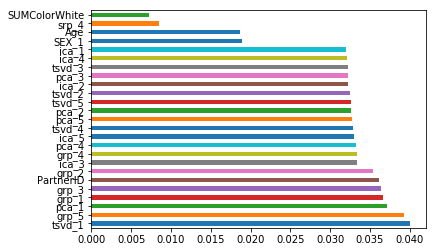

In [101]:
feat_importances = pd.Series(ExTC.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [30]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# fit a CART model to the data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))

             precision    recall  f1-score   support

          0       0.78      0.89      0.83    412957
          1       0.70      0.51      0.59    215492

avg / total       0.75      0.76      0.75    628449

[[366628  46329]
 [105121 110371]]
0.6999964953022748


In [26]:
y_train.value_counts()

0    1238871
1     646473
Name: Metal, dtype: int64

In [27]:
%%time
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV()
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)

Wall time: 1min 24s


In [32]:
# summarize the fit of the model
#print(metrics.classification_report(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))

0.7517887180717764


In [ ]:
from sklearn import metrics
#from sklearn.neighbors import KNeighborsClassifier
# fit a CART model to the data
model = KNeighborsClassifier()
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))

In [1]:
2+2

4